In [1]:
from unidec_modules.ChromEng2 import *
import plate_map2 as pm2
from dataclasses import dataclass
import pandas as pd
import UniChromExtra as uc
import matplotlib.pyplot as plt

In [2]:
spectra_path = "C:\\Users\\cm19ljc\\Documents\\GitHub\\UniDec\\mzML\\mzML.mzML"
map_path = "unichrom plate map example.xlsx"

In [3]:
eng = ChromEngine()
eng.load_mzml(spectra_path)
eng.config.chrom_peak_width = 0.05
eng.get_chrom_peaks(min = 1) # INSERT PLOT HERE


UniDec Engine v.4.4.0

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\UniDec\unidec_bin\UniDec.exe

UniDec Engine v.4.4.0

UniDec Path: C:\Users\cm19ljc\Documents\GitHub\UniDec\unidec_bin\UniDec.exe
Opening HDF5 File: C:\Users\cm19ljc\Documents\GitHub\UniDec\mzML\mzML.hdf5
Reading mzML: C:\Users\cm19ljc\Documents\GitHub\UniDec\mzML\mzML.mzML
[Warning] Not index found and build_index_from_scratch is False
Converted to gzip file to improve speed: C:\Users\cm19ljc\Documents\GitHub\UniDec\mzML\mzML.mzML.gz
Error getting TIC in mzML; trying to make it...
Imported Data. Constructing TIC
Done
1070 2
Noise Level: 0.03357343719702872 Window: 0.05
Bad Peak [0.419567   0.30422294] 0.23768299999999998 [0.419567, 0.65725]
Bad Peak [0.602767   0.24142904] 0.24183299999999996 [0.419567, 0.6614]
0.702967 0.14128400000000008
0.790233 0.16205000000000003
1.0312 0.13711000000000007
1.95747 0.1411800000000003
2.88835 0.13712999999999997
Bad Peak [3.76958    0.03455761] 0.8769500000000003 [3.7197, 4.59665

([array([0.702967  , 0.13838679]),
  array([0.790233  , 0.09750636]),
  array([1.0312    , 0.74873995]),
  array([1.95747   , 0.88543616]),
  array([2.88835, 1.     ])],
 array([[0.686333, 0.827617],
        [0.682183, 0.844233],
        [1.00212 , 1.13923 ],
        [1.9284  , 2.06958 ],
        [2.85927 , 2.9964  ]]))

Getting scans: [98, 131]
Length merge axis: 28915
Getting scans: [321, 355]
Length merge axis: 30293
Getting scans: [545, 578]
Length merge axis: 31336


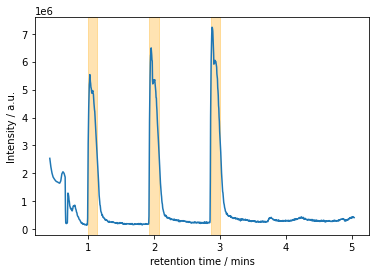

In [4]:
# eng.config.sw_scan_offset = 0 # ??? defaults to 10

eng.add_chrom_peaks2() # stores data from selected peaks ready for metaunidec processing
uc.plot_tic(eng, peak_windows = True)

In [5]:
eng.config.subtype = 2 # background subtraction - subtract curved
eng.config.subbuff = 100 # background subtraction amount(subtract curved) 0 = 0ff, 100 = good amount when on
eng.config.datanorm = 0 # turn off data normalisation

# -- Deconvolution
eng.config.numit = 100 # number of iterations

# mass range (default = 5000.0 to 500000.0 Da)
eng.config.massub = 15000 # upper 
eng.config.masslb = 11000 # lower

eng.config.massbins = 0.1 # sample mass every 0.1 Da

# FWHM 
# eng.get_auto_peak_width()
eng.config.mzsig = 0 

# charge range
eng.config.startz = 1
eng.config.endz = 30

# smoothing 
eng.config.zzsig = 1 # charge smooth width (smooth charge state distributions)
eng.config.psig = 1 # smooth nearby points (point smooth width, some = 1)
eng.config.beta = 0 # suppress artifacts (beta, some = 50)

eng.config.psfun = 0 # Peak shape function (gaussian, lorentzian, split G/L)

# -- Peak Selection and plotting
eng.config.peaknorm = 0 # Normalise peaks (0 = off)
eng.config.datanorm = 0
eng.config.peakwindow = 10 # peak window / Da
eng.config.exnorm = 0 # extract normalisation
eng.config.peakthresh = 0.05
# eng.config.nativeub = 10
# eng.config.nativelb = -10
eng.data.export_hdf5()

In [6]:
eng.process_data()
eng.run_unidec()
eng.pick_peaks() 
eng = uc.integrate_all(eng)

Execution Time: 0.36789820000000084
Execution Time: 2.3664474
Execution Time: 0.14676779999999923
Peak info saved to: C:\Users\cm19ljc\Documents\GitHub\UniDec\mzML\UniDec_Figures_and_Files\mzML_extracts.txt


In [7]:
# PLATE MAP PROCESSING STARTS HERE
rmap, pmap = pm2.read_in_long(map_path)
eng = pm2.update_vars(eng, pmap, skip_empty = True)
print(rmap)
print(pmap)

        Reaction  Species  Concentration Units     Mass Reagent_Type Sequence
0  17-05-21-CTB1      CTB           10.0    uM  13321.0           SM      NaN
1  17-05-21-CTB1  GVYQSRL           10.0    uM  13184.0           SM  GVYQSRL
2  17-05-21-CTB1     HC7D           10.0    uM  13595.0            C      NaN
3  17-05-21-CTB1   CTB-GV            NaN    uM  13627.0            P      NaN
     Type       Reaction Time  Valid
A1   Test  17-05-21-CTB1    0   True
A2   Test  17-05-21-CTB1   30   True
A3   Test  17-05-21-CTB1   60   True
B1  empty            NaN  NaN   True
B2  empty            NaN  NaN   True
B3  empty            NaN  NaN   True


In [8]:
eng = uc.integrate_all(eng)


In [9]:
reactions = uc.process(rmap, pmap, eng = eng)
reactions = uc.match_peaks(eng, reactions)

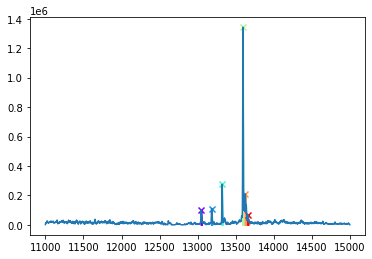

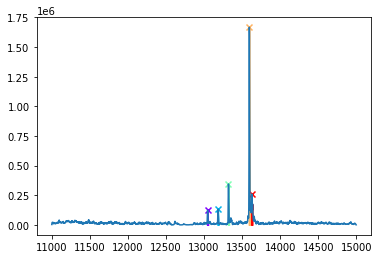

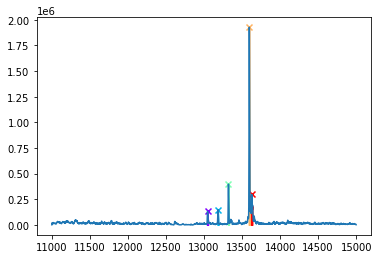

In [10]:
uc.plot_all(eng)

In [11]:
# best extraction of integral values for each species 
# prevents errors if different time points have a different number of peaks 
for rkey, rval in reactions.items():
    time = []
    speciesdct = {}
    speciestimedct = {}
    for t in rval:
        time.append(t.time)
        for s in t.species:
            if s.name in speciesdct:
                speciesdct[s.name].append(s.integral)
                speciestimedct[s.name].append(t.time)
            else:
                speciesdct[s.name] = [s.integral]
                speciestimedct[s.name] = [t.time]
speciesdct, speciestimedct

({'CTB': [2394619.5, 2955347.0, 3389886.2],
  'CTB-GV': [2706878.0, 3285878.0, 3731566.0],
  'GVYQSRL': [1154638.2, 1171638.2, 1345707.9],
  'HC7D': [11643148.0, 14578023.0, 16745840.0]},
 {'CTB': ['0', '30', '60'],
  'CTB-GV': ['0', '30', '60'],
  'GVYQSRL': ['0', '30', '60'],
  'HC7D': ['0', '30', '60']})

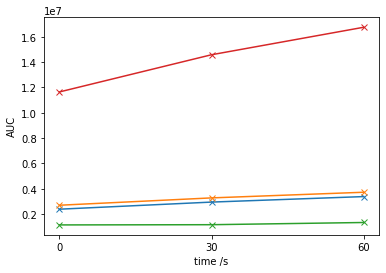

In [12]:
for key, val in speciesdct.items():
    plt.plot(speciestimedct[key], val, marker = 'x')
    plt.xlabel('time /s')
    plt.ylabel('AUC')
plt.show()
    

In [13]:
for rkey, rval in reactions.items():
    
    data, time = uc.get_data_from_dct(rval, rkey)
    uc.plot_data(data, time)

TypeError: list indices must be integers or slices, not str